In [1]:
import keras
from keras.datasets import cifar10
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [3]:
num_classes = 10
# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import numpy as np

In [ ]:
#Замораживаем слои.Отрезаем последний слой.
model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [7]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)
# define new model.
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [8]:
# initiate optimizer
opt = keras.optimizers.Adam(learning_rate=0.0005)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [9]:
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=1,
              validation_data=(x_test, y_test),
              shuffle=True)

391/391 [==============================] - 1652s 4s/step - loss: 1.2357 - accuracy: 0.6067 - val_loss: 0.9816 - val_accuracy: 0.6571


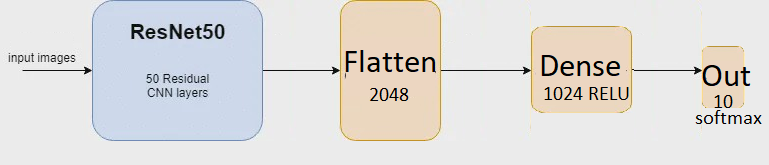

In [148]:
#Создадим матрицу confusion
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Normalized confusion matrix


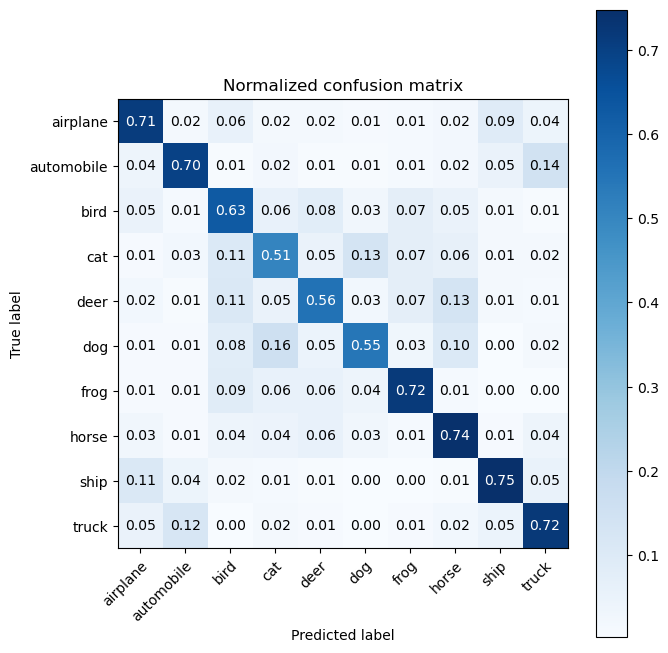

In [122]:
y_pred=np.argmax(model.predict(x_test), axis=1)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [61]:
#соединим cifar10 и cifar100
from keras.datasets import cifar100
(x_train2, y_train2_fine), (x_test2, y_test2_fine) = cifar100.load_data('fine')
(x_train2, y_train2_coarse), (x_test2, y_test2_coarse) = cifar100.load_data('coarse')

In [62]:
#coarse определяет какой суперкласс это. Из 20 суперклассов. 
y_train2_coarse

array([[11],
       [15],
       [ 4],
       ...,
       [ 8],
       [ 7],
       [ 1]])

In [52]:
y_train2.shape

(50000, 1)

In [53]:
y_train2[:10]

array([[19],
       [29],
       [ 0],
       [11],
       [ 1],
       [86],
       [90],
       [28],
       [23],
       [31]])

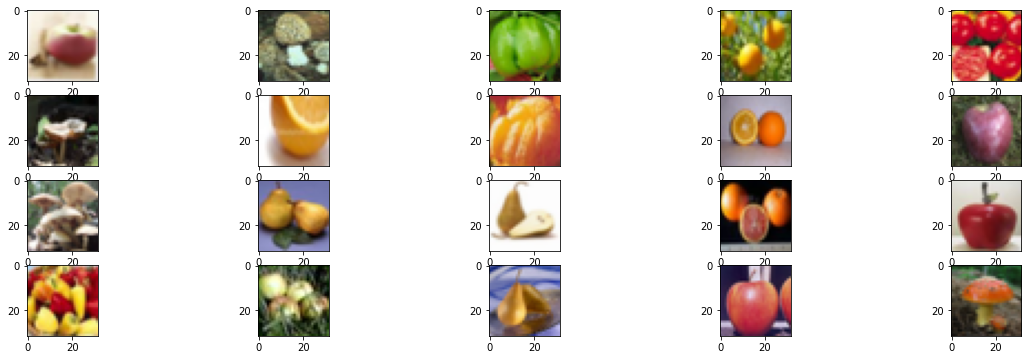

In [95]:
#Смотрим те картинки, которые принадлежат к супер-классу 4
# 20 рандомных картинок из 4 супер-класса
plt.figure(figsize=(20,6))

for i in range(4):
    for j in range(5):
        plt.subplot(4,5,i*5 + j + 1)
        plt.imshow(x_train2[(y_train2_coarse == 4).squeeze()][i*5 + j])


In [116]:
#технический момент для запуска без ошибок
x_train2_fr_veg = x_train2[(y_train2_coarse == 4).squeeze()]
y_train2_fr_veg = y_train2[(y_train2_coarse == 4).squeeze()]

x_test2_fr_veg = x_test2[(y_test2_coarse == 4).squeeze()]
y_test2_fr_veg = y_test2[(y_test2_coarse == 4).squeeze()]

In [99]:
#Номера классов из 4-ого класса
np.unique(y_test2_fr_veg)

array([ 0, 51, 53, 57, 83])

In [117]:
#нумеруем. Тот, кто нулем, станет 10 в итоге.
y_test2_fr_veg[y_test2_fr_veg == 0] = 10
y_test2_fr_veg[y_test2_fr_veg == 51] = 11
y_test2_fr_veg[y_test2_fr_veg == 53] = 12
y_test2_fr_veg[y_test2_fr_veg == 57] = 13
y_test2_fr_veg[y_test2_fr_veg == 83] = 14

y_train2_fr_veg[y_train2_fr_veg == 0] = 10
y_train2_fr_veg[y_train2_fr_veg == 51] = 11
y_train2_fr_veg[y_train2_fr_veg == 53] = 12
y_train2_fr_veg[y_train2_fr_veg == 57] = 13
y_train2_fr_veg[y_train2_fr_veg == 83] = 14

In [118]:
#Соединяем цифар 10 и цифар 100
x_train_together = np.concatenate((x_train, x_train2_fr_veg))
x_test_together = np.concatenate((x_test, x_test2_fr_veg))

y_train_together = np.concatenate((np.argmax(y_train, axis=1).reshape((-1, 1)), y_train2_fr_veg))
y_test_together = np.concatenate((np.argmax(y_test, axis=1).reshape((-1, 1)), y_test2_fr_veg))


In [119]:
#Убеждаемся в правильности размера
print(x_train_together.shape)
print(x_test_together.shape)
print(y_train_together.shape)
print(y_test_together.shape)

(52500, 32, 32, 3)
(10500, 32, 32, 3)
(52500, 1)
(10500, 1)


In [139]:
num_classes = 15

y_train_together = keras.utils.to_categorical(y_train_together, num_classes)
y_test_together = keras.utils.to_categorical(y_test_together, num_classes)

print(x_train_together.shape)
print(x_test_together.shape)
print(y_train_together.shape)
print(y_test_together.shape)

(52500, 32, 32, 3)
(10500, 32, 32, 3)
(52500, 15)
(10500, 15)


In [130]:
#Обрабатываем картинки
x_train_together = preprocess_input(x_train_together)
x_test_together = preprocess_input(x_test_together)

In [129]:
#Новая модель из-за того, что старая обучалась на 10 классах, а теперь их 15
new_model = Model(model.inputs, model.layers[-2].output)

new_output = Dense(15, activation='softmax')(new_model.layers[-1].output)
new_model = Model(new_model.inputs, new_output)

new_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [140]:

opt = keras.optimizers.Adam(learning_rate=0.0005)
#Заморозили предпоследний слой, который делает всю работу классификатора. 
#Так как проще обучить последний слой из 15 нейронов. 
new_model.layers[-2].trainable = False
new_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = new_model.fit(x_train_together, y_train_together,
              batch_size=128,
              epochs=1,
              validation_data=(x_test_together, y_test_together),
              shuffle=True)

411/411 [==============================] - 1689s 4s/step - loss: 1.6337 - accuracy: 0.4411 - val_loss: 1.3368 - val_accuracy: 0.5372


Normalized confusion matrix


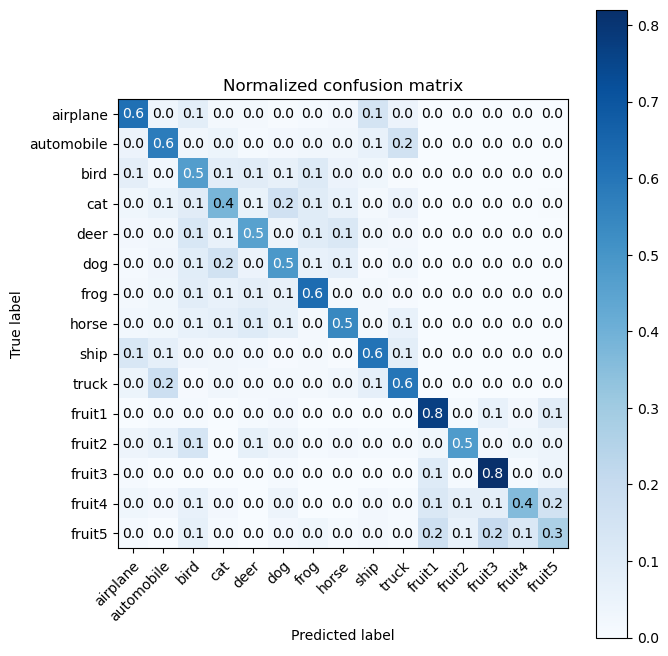

In [149]:
#Та же самая нейронная сеть, только изменили последний слой.Таким образом она научилась еще 5 классов определять.
y_pred=np.argmax(new_model.predict(x_test_together), axis=1)
y_true=np.argmax(y_test_together,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 
            'fruit1', 'fruit2', 'fruit3', 'fruit4', 'fruit5']

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [151]:
#Размораживаем предпоследний слой.Проводи еще одну эпоху обучения классификатора. 
opt = keras.optimizers.Adam(learning_rate=0.001)

new_model.layers[-2].trainable = True
new_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = new_model.fit(x_train_together, y_train_together,
              batch_size=128,
              epochs=1,
              validation_data=(x_test_together, y_test_together),
              shuffle=True)

411/411 [==============================] - 1717s 4s/step - loss: 1.2092 - accuracy: 0.5828 - val_loss: 1.0984 - val_accuracy: 0.6189


In [ ]:
#Для confusion matrix
y_pred_sparse = new_model.predict(x_test_together)

y_pred=np.argmax(y_pred_sparse, axis=1)
y_true=np.argmax(y_test_together,axis=1)

Normalized confusion matrix


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

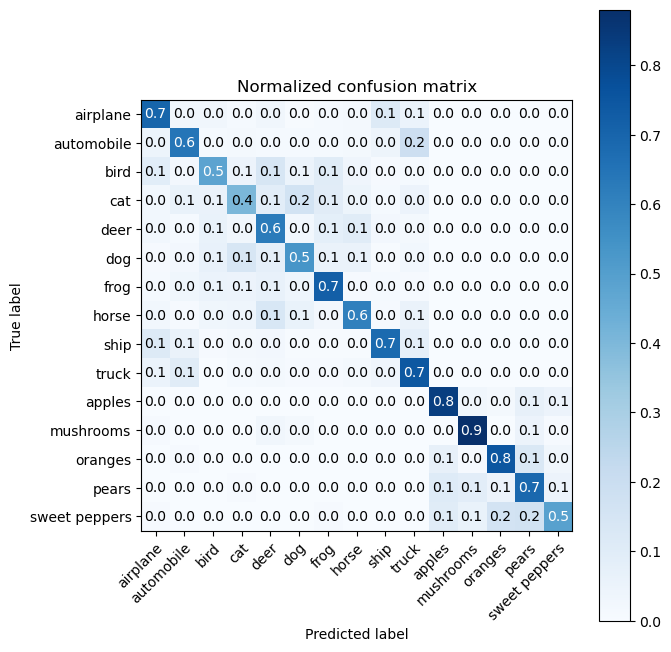

In [158]:

class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 
            'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers']

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [160]:
#precision, accuracy, f1-score
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.70      0.66      1000
           1       0.65      0.64      0.65      1000
           2       0.60      0.48      0.53      1000
           3       0.52      0.40      0.45      1000
           4       0.51      0.62      0.56      1000
           5       0.59      0.53      0.56      1000
           6       0.65      0.72      0.68      1000
           7       0.66      0.61      0.63      1000
           8       0.72      0.68      0.70      1000
           9       0.61      0.74      0.67      1000
          10       0.75      0.83      0.79       100
          11       0.81      0.88      0.84       100
          12       0.77      0.75      0.76       100
          13       0.62      0.69      0.65       100
          14       0.78      0.49      0.60       100

    accuracy                           0.62     10500
   macro avg       0.66      0.65      0.65     10500
weighted avg       0.62   